## **Data Cleaning: Posts**

##### **Imports**

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import os

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set_theme(palette='crest')

##### **Read in data saved in ./datasets folder**

In [38]:
files = os.listdir('posts_data/')
data_folder = 'posts_data/'
list_dataframe=[]
for file in files:
    file = pd.read_csv(data_folder+file)
    list_dataframe.append(file)
df = pd.concat([list_dataframe[0],list_dataframe[1]], ignore_index=True)
df.drop(columns='Unnamed: 0', inplace=True)
print(df.shape)

(53819, 6)


##### **Quick look at the first 5 rows of the dataframe**

In [39]:
df.head()

,title,author,created_utc,selftext,score,subreddit
0,Why do we vomit when we are too hot?,childloser,1627143368,[removed],1,askscience
1,How much CO2 is released by manufacturing a ki...,banmeyoucoward,1627143292,[removed],1,askscience
2,Is the level of AI portrayed in movies (fully ...,SchoolThrow123,1627143240,[removed],1,askscience
3,Why do some animals have moustache and whiskers,notowork,1627143114,[removed],1,askscience
4,What is the maximal theoretical size for an an...,Vantaie,1627142862,[removed],1,askscience


##### **Evaluate for any duplicated rows and remove from dataframe**

In [40]:
df.drop_duplicates(inplace=True,ignore_index=True)

##### **Evaluate nulls, [removed], and [deleted] posts**
###### 300 out of >53,000 posts that have no selftext other than [removed] or [deleted]

In [42]:
print((df['selftext'] == "[removed]").sum())
print((df['selftext'] == "[deleted]").sum())
print((df['selftext'].isna().sum()))

37190
410
13274


##### **Explore [removed] and [deleted] posts further**

In [43]:
df[(df['selftext'] == '[removed]')|(df['selftext'] == '[deleted]')].groupby('selftext')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
selftext,,,,,,,,
[deleted],410.0,2.480488,5.015464,0.0,1.0,1.0,1.0,44.0
[removed],37190.0,1.072654,1.782989,0.0,1.0,1.0,1.0,149.0


In [44]:
df[(df['selftext'] == '[removed]')|(df['selftext'] == '[deleted]')].groupby('selftext')['author'].value_counts()
df = df[(df['author'] != "[deleted]") & (df['selftext'] != "[deleted]")]

In [45]:
df[(df['selftext'] == '[removed]')].groupby('selftext')['subreddit'].value_counts()

selftext   subreddit 
[removed]  askscience    34915
           longevity      2248
Name: subreddit, dtype: int64

In [46]:
removed_selftext = df[(df['selftext'] == '[removed]')]
removed_selftext.head()

,title,author,created_utc,selftext,score,subreddit
0,Why do we vomit when we are too hot?,childloser,1627143368,[removed],1,askscience
1,How much CO2 is released by manufacturing a ki...,banmeyoucoward,1627143292,[removed],1,askscience
2,Is the level of AI portrayed in movies (fully ...,SchoolThrow123,1627143240,[removed],1,askscience
3,Why do some animals have moustache and whiskers,notowork,1627143114,[removed],1,askscience
4,What is the maximal theoretical size for an an...,Vantaie,1627142862,[removed],1,askscience


##### **Replace all [removed], [deleted], and null values in self text**

In [47]:
# Replace posts with selftext [removed] and [deleted] with empty string
df.replace({'selftext': {'[removed]':'', '[deleted]':''}}, inplace=True)

# Replace posts with null values for selftext with empty string
df.fillna({'selftext':''}, inplace=True)

# combine selftext with title and create new column
df['text'] = df['title'] + df['selftext']

# drop selftext column
df.drop(columns='selftext', inplace=True)

##### **Apply regex function to all rows in text with lambda function**

In [48]:
df['text'] = df['text'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))

**Create labels for subreddits**

In [49]:
subreddit_dict = {'longevity':0,
            'askscience':1}
df['subreddit'] = df['subreddit'].map(subreddit_dict)

In [50]:
df.head()

,title,author,created_utc,score,subreddit,text
0,Why do we vomit when we are too hot?,childloser,1627143368,1,1,Why do we vomit when we are too hot
1,How much CO2 is released by manufacturing a ki...,banmeyoucoward,1627143292,1,1,How much CO is released by manufacturing a ki...
2,Is the level of AI portrayed in movies (fully ...,SchoolThrow123,1627143240,1,1,Is the level of AI portrayed in movies fully ...
3,Why do some animals have moustache and whiskers,notowork,1627143114,1,1,Why do some animals have moustache and whiskers
4,What is the maximal theoretical size for an an...,Vantaie,1627142862,1,1,What is the maximal theoretical size for an an...


##### **Save cleaned dataframe as CSV file**

In [51]:
df.to_csv('posts.csv')

## **Data Cleaning: Comments**

##### **Read in comments data .csv file as dataframe**

In [79]:
files = os.listdir('comments_data/')
data_folder = 'comments_data/'
list_dataframe=[]
for file in files:
    file = pd.read_csv(data_folder+file)
    list_dataframe.append(file)
df = pd.concat([list_dataframe[0],list_dataframe[1]], ignore_index=True)
df.drop(columns='Unnamed: 0', inplace=True)
print(df.shape)

(50900, 5)


##### **Display first 5 rows of dataframe**

In [80]:
df.head()

,author,body,score,created_utc,subreddit
0,[deleted],[removed],1,1627143248,askscience
1,AutoModerator,"Thank you for your submission! Unfortunately, ...",1,1627143115,askscience
2,RobusEtCeleritas,None of that means anything. You clearly have ...,3,1627142891,askscience
3,iayork,"Thank you for your submission! Unfortunately, ...",1,1627142729,askscience
4,iayork,"Thank you for your submission! Unfortunately, ...",1,1627142722,askscience


##### **Quick overview of total null values in each column and data type of each column**

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50900 entries, 0 to 50899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       50900 non-null  object
 1   body         50900 non-null  object
 2   score        50900 non-null  int64 
 3   created_utc  50900 non-null  int64 
 4   subreddit    50900 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


###### For all comments with body "[deleted]", author is also "[deleted]"; We should remove these rows

In [82]:
df = df[df['body'] != "[deleted]"]

###### For all rows with author "AutoModerator", the comment 'body' is an automated statement explaining that the post has been removed or deleted due to violation of guidelines. Remove these rows with author as AutoModerator

In [83]:
df = df[df['author']!='AutoModerator']

###### Remove all rows that contain the word 'removed' in the comment 'body' as this is another indication that the post has been removed or deleted due to violation of guidelines

In [84]:
not_removed = [x for x in df['body'] if 'removed' not in x]
for x in df['body']:
    if x not in not_removed:
        df['body'].replace(to_replace=x, value=np.nan, inplace=True)

##### **Remove all rows with null value in comment 'body'**

In [85]:
df = df[df['body'].notna()]

##### **Remove all rows where comment 'body' is duplicated**

In [86]:
df.drop_duplicates(subset='body', inplace=True)
df.head()

,author,body,score,created_utc,subreddit
2,RobusEtCeleritas,None of that means anything. You clearly have ...,3,1627142891,askscience
15,hydroxypcp,The legal limit varies among countries. It's c...,0,1627140964,askscience
20,AnthillOmbudsman,But magma chambers aren't hollow caverns. I'm...,1,1627140360,askscience
28,AWormDude,[According to this study](https://www.research...,5,1627139388,askscience
43,Trypanosoma_,Look up TH1 (cellular response) vs TH2 (humora...,-4,1627136260,askscience


###### **Assessing shape after all drops**

In [87]:
df.shape

(31115, 5)

##### **Create a new row of the word count in body for each comment**

In [88]:
df['body_word_count'] = [len(x.split()) for x in df['body']]

##### **Apply Regex by lambda function for comment 'body'**

In [89]:
df['body'] = df['body'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))

In [90]:
df.head()

,author,body,score,created_utc,subreddit,body_word_count
2,RobusEtCeleritas,None of that means anything You clearly have ...,3,1627142891,askscience,11
15,hydroxypcp,The legal limit varies among countries It s c...,0,1627140964,askscience,130
20,AnthillOmbudsman,But magma chambers aren t hollow caverns I m...,1,1627140360,askscience,14
28,AWormDude,According to this study https www research...,5,1627139388,askscience,487
43,Trypanosoma_,Look up TH cellular response vs TH humora...,-4,1627136260,askscience,57


##### **Binarize 'subreddit' with map function for EDA and modeling**

In [91]:
subreddit_dict = {'longevity':0,
            'askscience':1}
df['subreddit'] = df['subreddit'].map(subreddit_dict)

##### **Quick evaluation of scores on comments in the dataframe**

In [92]:
df['score'].describe()

count    31115.000000
mean         9.748289
std        124.431942
min        -54.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       8542.000000
Name: score, dtype: float64

##### **Quick check of null values and data types after all cleaning for EDA and modeling**

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31115 entries, 2 to 50899
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   author           31115 non-null  object
 1   body             31115 non-null  object
 2   score            31115 non-null  int64 
 3   created_utc      31115 non-null  int64 
 4   subreddit        31115 non-null  int64 
 5   body_word_count  31115 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.7+ MB


##### **Save cleaned dataframe into CSV file**

In [94]:
df.to_csv('comments.csv')

#### **Will move forward with comments data from this point. The majority of the text from posts are titles of journal articles which will not be helpful**

# EDA and Visualizations

##### Dataframe is unbalanced; There are more comments from subreddit longevity (represented by 0) than subreddit askscience (represented by 1)

In [249]:
df.subreddit.value_counts()

0    21774
1     9341
Name: subreddit, dtype: int64

##### **Mean scores and word count grouped by subreddit**

In [245]:
df.groupby('subreddit')[['score', 'body_word_count']].mean()

,score,body_word_count
subreddit,,
0,3.003628,42.777671
1,25.470185,60.068836


> Subreddit r/longevity represented by 0 has a lower mean score compared to subreddit r/askscience represented by 1. Despite unbalanced classes, comment score mean for longevity subreddit is significant smaller than average comment score for askscience subreddit

##### **Create a visualization of distribution of word count in each comment**

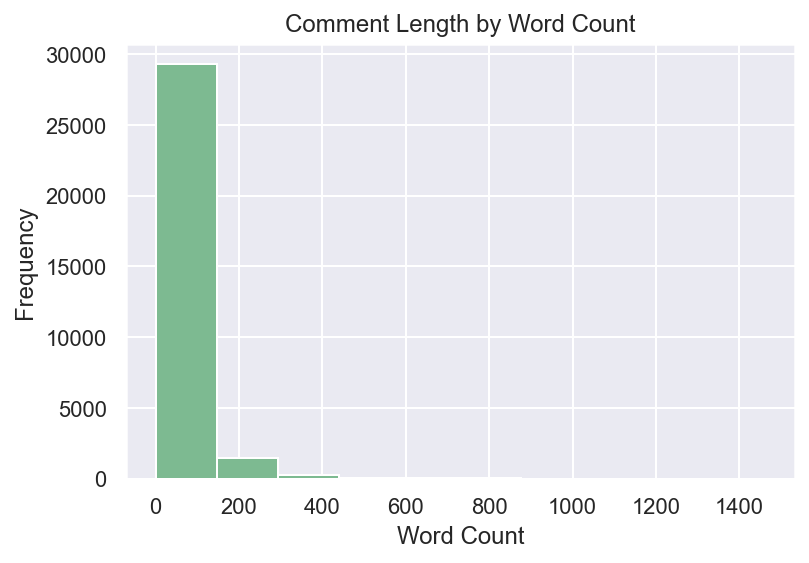

In [272]:
# Create histogram for distribution on word count
sns.set_theme(palette='crest')
plt.hist(df['body_word_count'], bins=10)
plt.title("Comment Length by Word Count")
plt.ylabel('Frequency')
plt.xlabel('Word Count');
plt.savefig('comment_length_word_count.png')

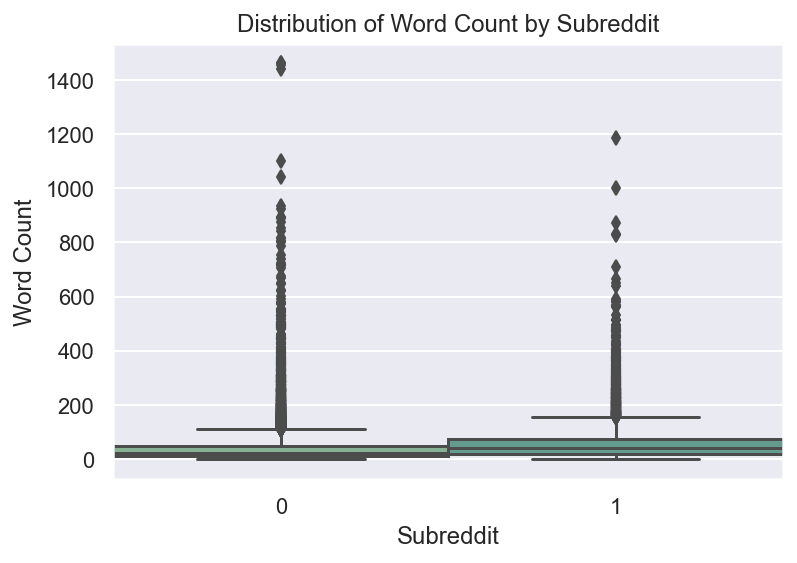

In [279]:
# Create a boxplot to visualize distribution of word count by subreddit
sns.set_theme(palette='crest')
sns.boxplot(x=df['subreddit'], y=df['body_word_count'], width=1.0)
plt.title("Distribution of Word Count by Subreddit")
plt.xlabel('Subreddit')
plt.ylabel('Word Count');

##### Split dataframe by subreddit to evaluate top words

In [140]:
asksci=df[df['subreddit'] ==1]
longevity=df[df['subreddit']==0]

##### Remove stopwords and a list of stopwords after evaluating

In [141]:
all_stop_words = stopwords.words('english')
new_words=('https', 'com', 'www', 'really', 'would', 'like', 'also', 'get', 'even', 'much', 'could', 'see', 'really', 'know')
for i in new_words:
    all_stop_words.append(i)

##### Instantiate CountVectorizer and create dataframe

In [148]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words = all_stop_words, max_features=500)

# Fit and transform CountVectorizer; this is just for visualization of most frequently used words
asksci_transformed=(cvec.fit_transform(asksci['body']))

# get feature names and set as variable
asksci_feature_names = cvec.get_feature_names()

# set list of feature names as dataframe and condense vectorized data
asksci_transformed=pd.DataFrame(asksci_transformed.todense())
# set columns as feature names
asksci_transformed.columns = asksci_feature_names

##### Top 20, most frequent words in Askscience comments

In [280]:
# set as dataframe
asksci_top_20 = pd.DataFrame(asksci_transformed.sum().sort_values(ascending = False).head(20))

In [154]:
asksci_transformed.sum().sort_values(ascending = False).head(20)

one          1501
time         1313
people       1126
still         986
different     887
light         861
way           829
years         822
think         808
cells         768
earth         759
water         740
energy        733
make          729
gt            700
point         674
use           670
many          657
well          655
speed         639
dtype: int64

##### Create visualization for top 20 most frequently occurring words in Askscience comments

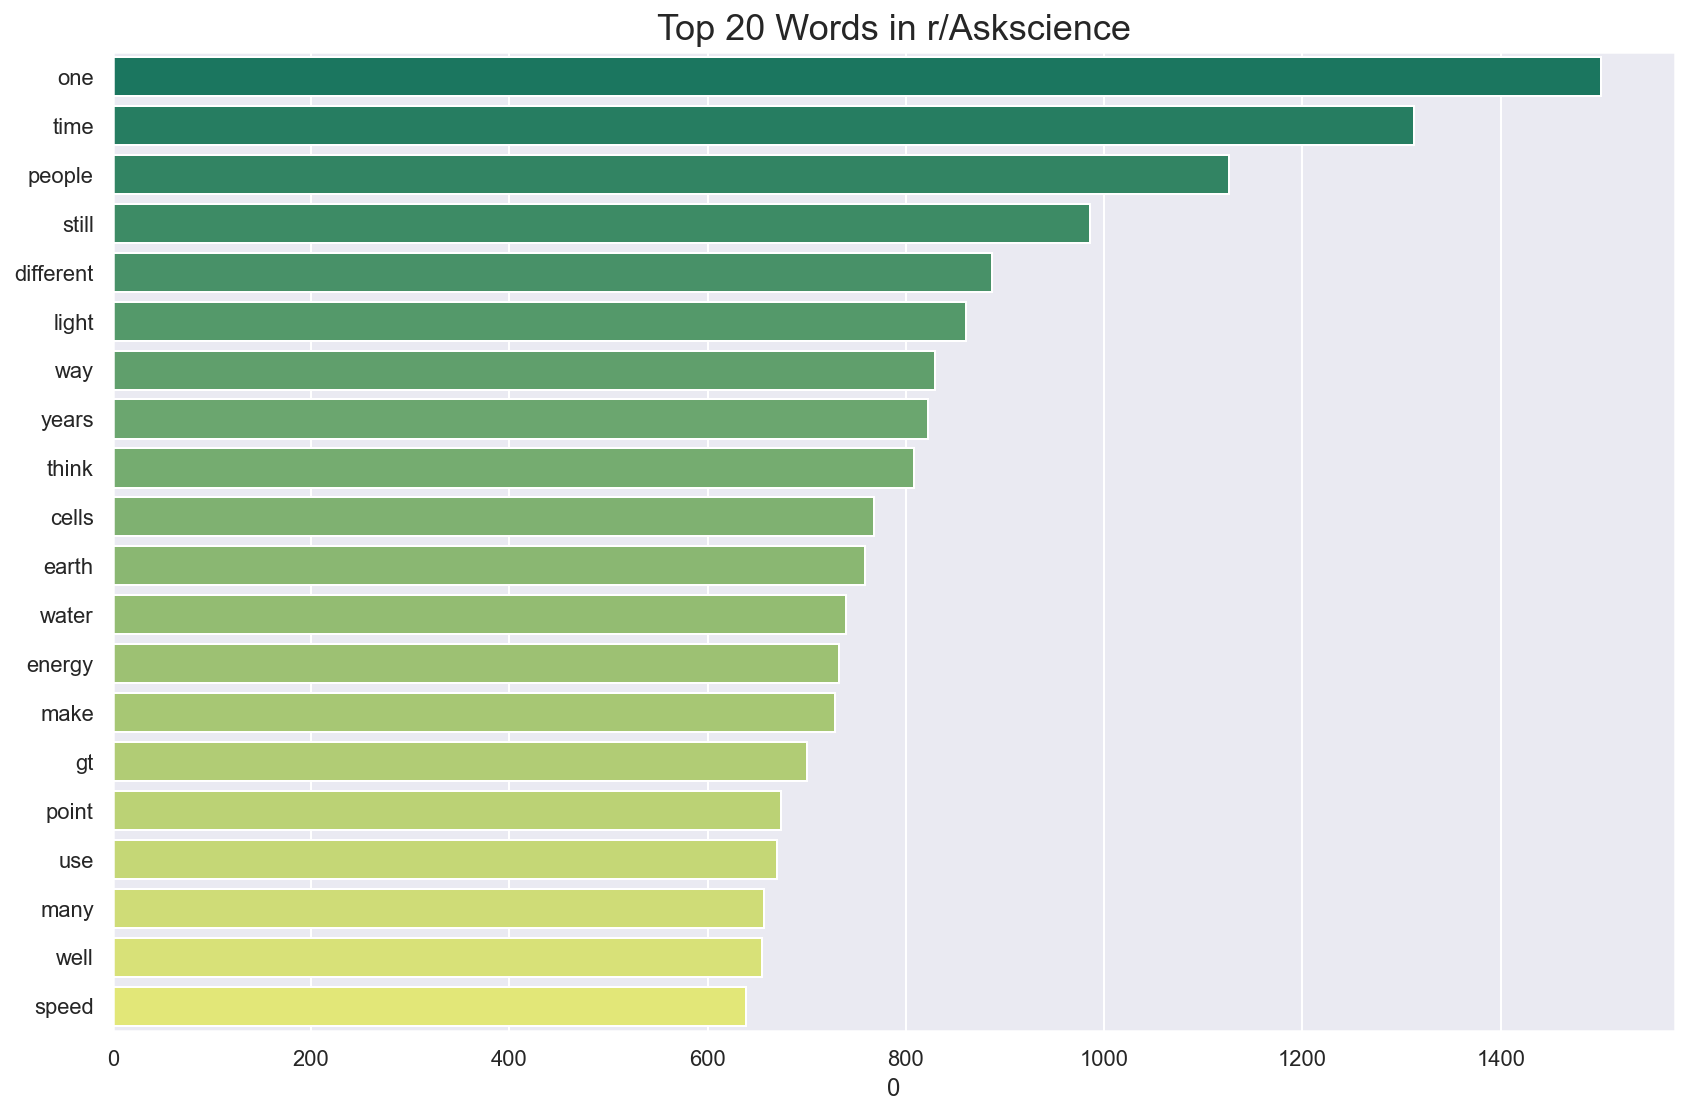

In [283]:
# Visualization made possible by Varun
plt.figure(figsize=(14,9))
plt.title('Top 20 Words in r/Askscience',fontsize=18)
sns.barplot(x=asksci_top_20[0], y=asksci_top_20.index, palette='summer');
plt.savefig('top_20_Askscience.png')

##### Will do the same for subreddit Longevity

In [186]:
cvec = CountVectorizer(stop_words = all_stop_words, max_features=500)
longevity_transformed=(cvec.fit_transform(longevity['body']))
longevity_feature_names = cvec.get_feature_names()
longevity_transformed=pd.DataFrame(longevity_transformed.todense())
longevity_transformed.columns = longevity_feature_names

In [187]:
longevity_top_20 = pd.DataFrame(longevity_transformed.sum().sort_values(ascending = False).head(20))

In [188]:
longevity_transformed.sum().sort_values(ascending = False).head(20)

aging        4230
people       3923
gt           3337
longevity    2786
think        2636
years        2421
age          2395
one          2319
research     1920
old          1854
life         1798
time         1726
good         1655
cells        1609
well         1460
cancer       1350
way          1241
make         1216
disease      1190
reddit       1173
dtype: int64

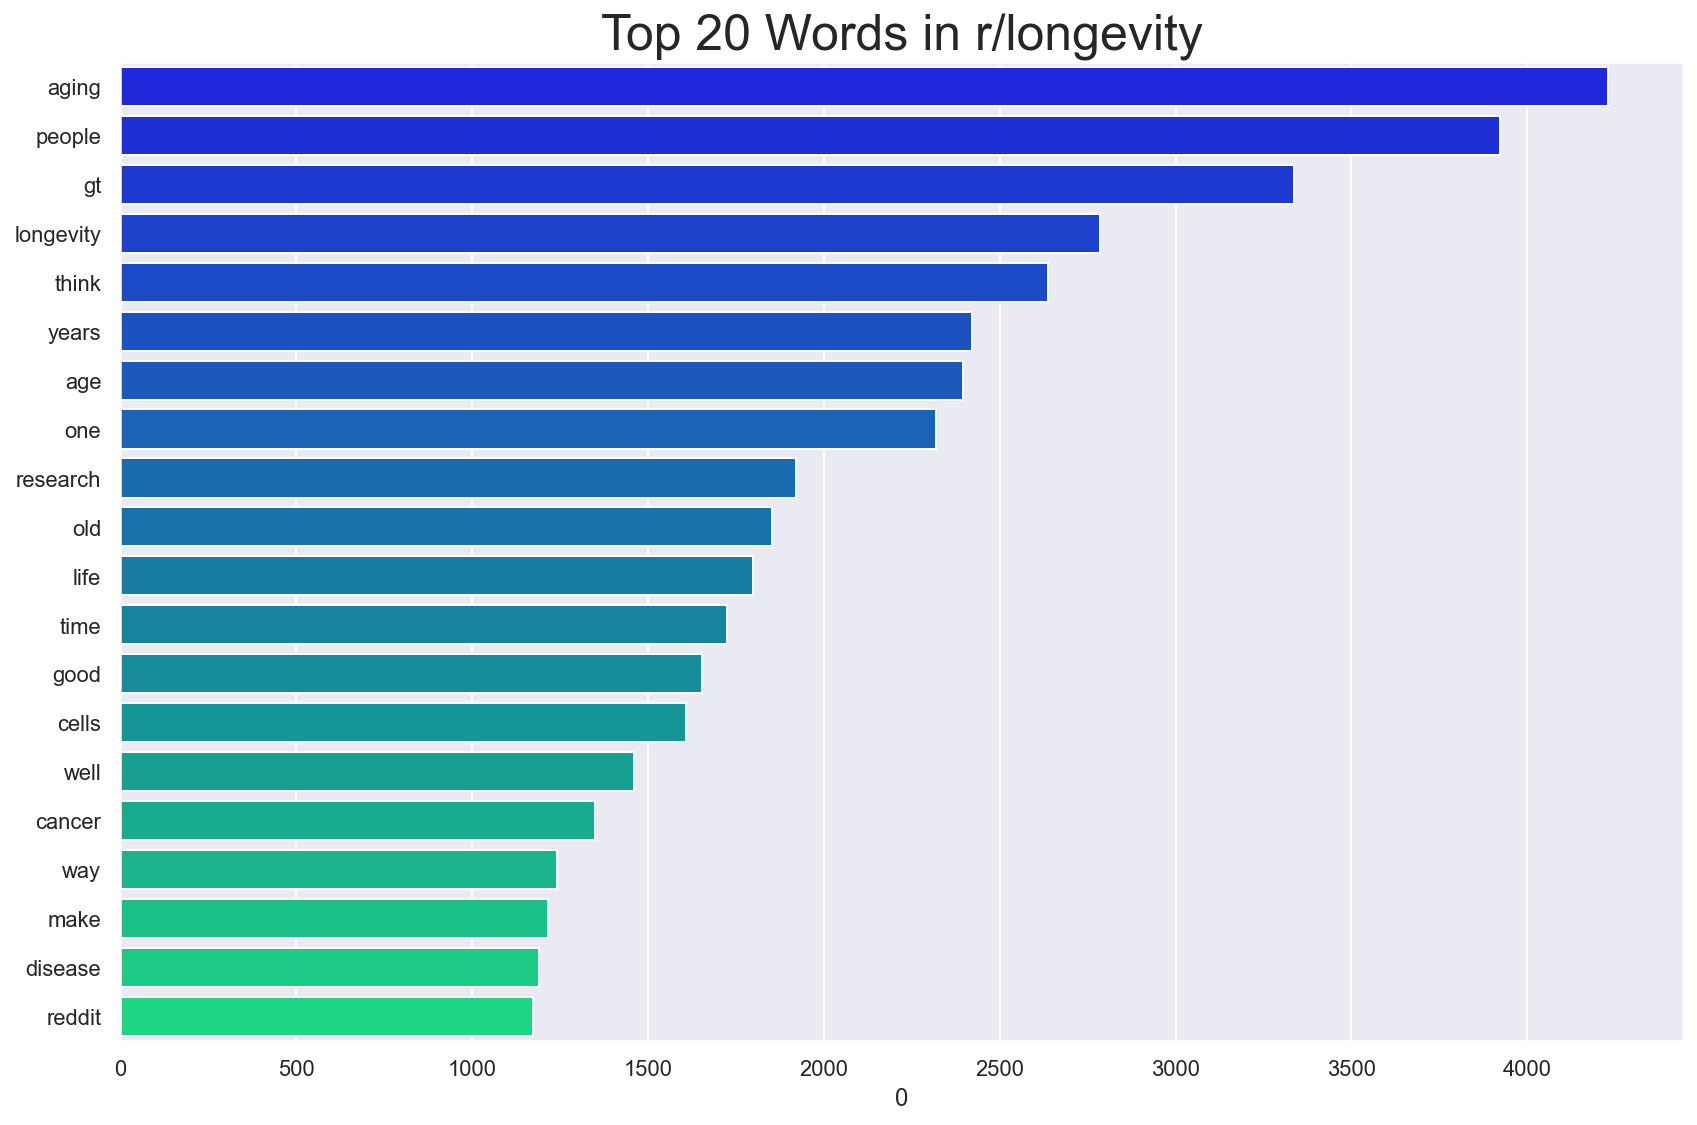

In [234]:
plt.figure(figsize=(14,9))
plt.title('Top 20 Words in r/longevity',fontsize=25)
sns.barplot(x=longevity_top_20[0], y=longevity_top_20.index, palette='winter');
sns.set_theme(context='notebook')
plt.savefig('top_20_longevity.png')